In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
# ... import others as needed

In [6]:
df = pd.read_csv('C:\\sacha study area\\customer churn dataset_ML task\\WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.head(2))


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   

      PaymentMethod MonthlyCharges  TotalCharges Churn  
0  Electronic check          29.85         29.85    No  
1      Mailed check          56.95        1889.5    No  

[2 rows x 21 columns]


In [7]:
print(df.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [10]:
print(df.apply(lambda col: col.unique()))

customerID          [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...
gender                                                 [Female, Male]
SeniorCitizen                                                  [0, 1]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
tenure              [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...
PhoneService                                                [No, Yes]
MultipleLines                             [No phone service, No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                         [No, Yes, No internet service]
OnlineBackup                           [Yes, No, No internet service]
DeviceProtection                       [No, Yes, No internet service]
TechSupport                            [No, Yes, No internet service]
StreamingTV                            [No, Yes, No internet service]
StreamingMovies     

In [11]:
#dropping customer ID
df = df.drop('customerID', axis=1)

In [13]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [14]:
total_charges_series = df['TotalCharges']
converted_series = pd.to_numeric(total_charges_series, errors='coerce')
df['TotalCharges'] = converted_series

nan_count = df['TotalCharges'].isnull().sum()
print("NaNs in TotalCharges after conversion:", nan_count)

if nan_count > 0:
    nan_rows = df['TotalCharges'].isnull()
    filtered_df = df[nan_rows]
    selected_columns = filtered_df[['tenure', 'MonthlyCharges', 'TotalCharges']]
    print("Rows with NaN TotalCharges:\n", selected_columns)

NaNs in TotalCharges after conversion: 11
Rows with NaN TotalCharges:
       tenure  MonthlyCharges  TotalCharges
488        0           52.55           NaN
753        0           20.25           NaN
936        0           80.85           NaN
1082       0           25.75           NaN
1340       0           56.05           NaN
3331       0           19.85           NaN
3826       0           25.35           NaN
4380       0           20.00           NaN
5218       0           19.70           NaN
6670       0           73.35           NaN
6754       0           61.90           NaN


In [15]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [18]:
print(df['TotalCharges'].isna().sum())

0


In [20]:
# Imports (run once if not already)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline   

C:\Users\nivia\AppData\Local\Temp\ipykernel_19736\2722609726.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


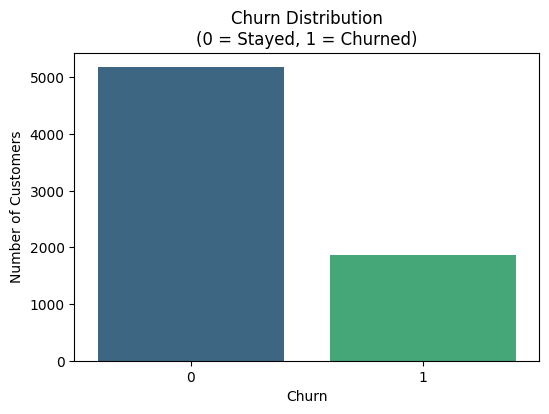

Churn percentages:
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Churn Distribution\n(0 = Stayed, 1 = Churned)')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.show()

print("Churn percentages:")
print(df['Churn'].value_counts(normalize=True).round(4) * 100)

C:\Users\nivia\AppData\Local\Temp\ipykernel_19736\3269544928.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0], palette='viridis')
C:\Users\nivia\AppData\Local\Temp\ipykernel_19736\3269544928.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1], palette='viridis')
C:\Users\nivia\AppData\Local\Temp\ipykernel_19736\3269544928.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='TotalCharges', data=df, ax=axes[2], palette='viridis')


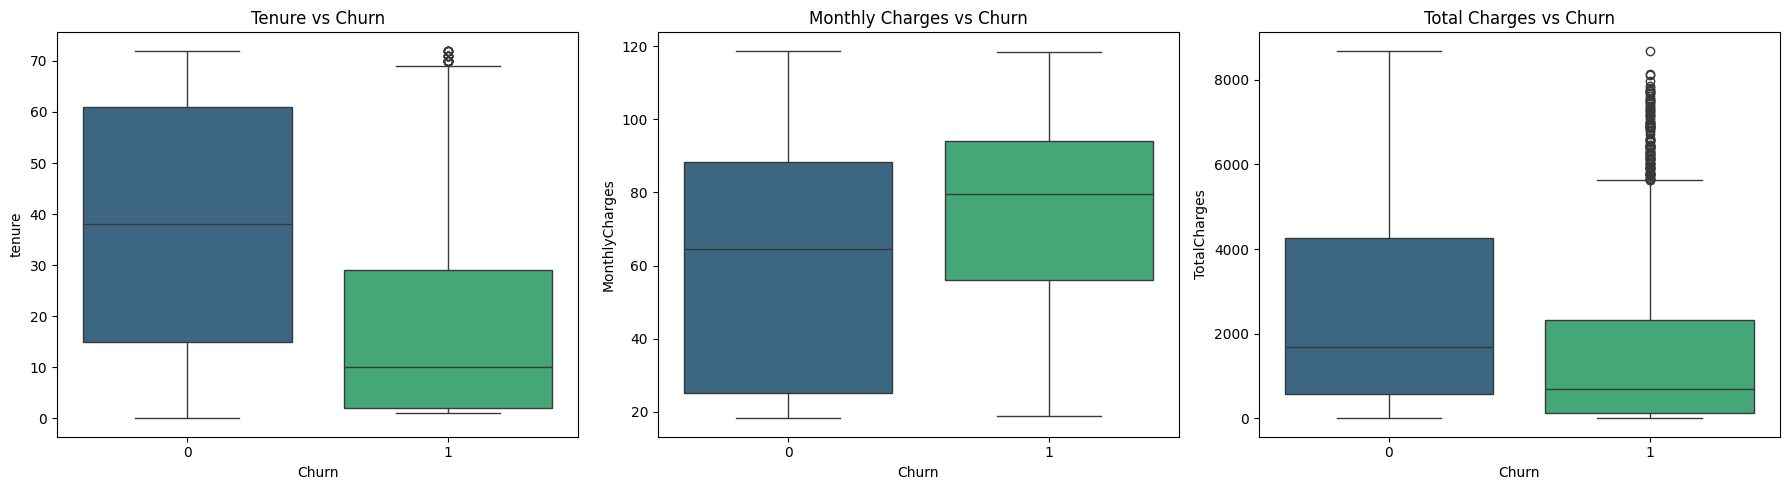

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Tenure vs Churn')

sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Monthly Charges vs Churn')

sns.boxplot(x='Churn', y='TotalCharges', data=df, ax=axes[2], palette='viridis')
axes[2].set_title('Total Charges vs Churn')

plt.tight_layout()
plt.show()

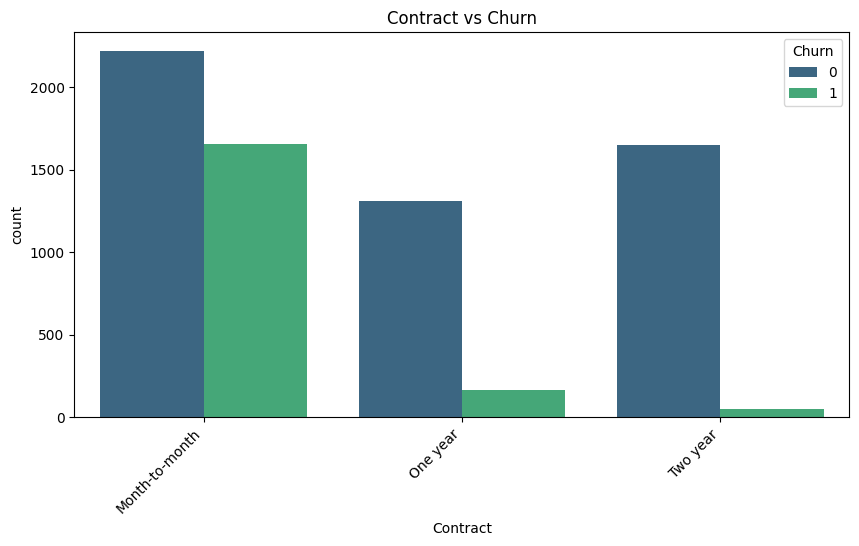

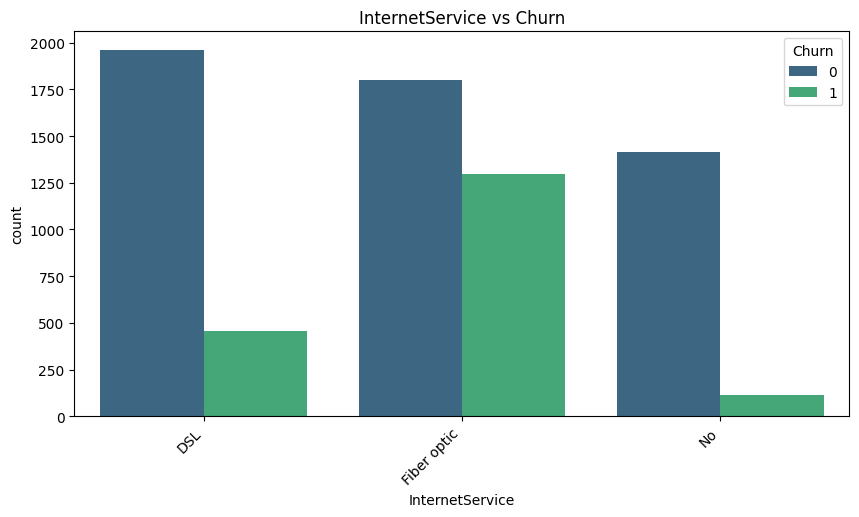

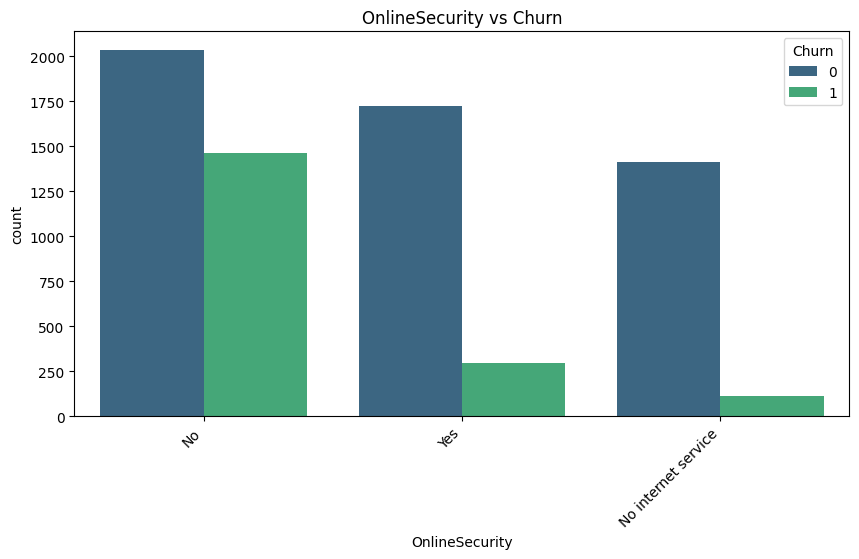

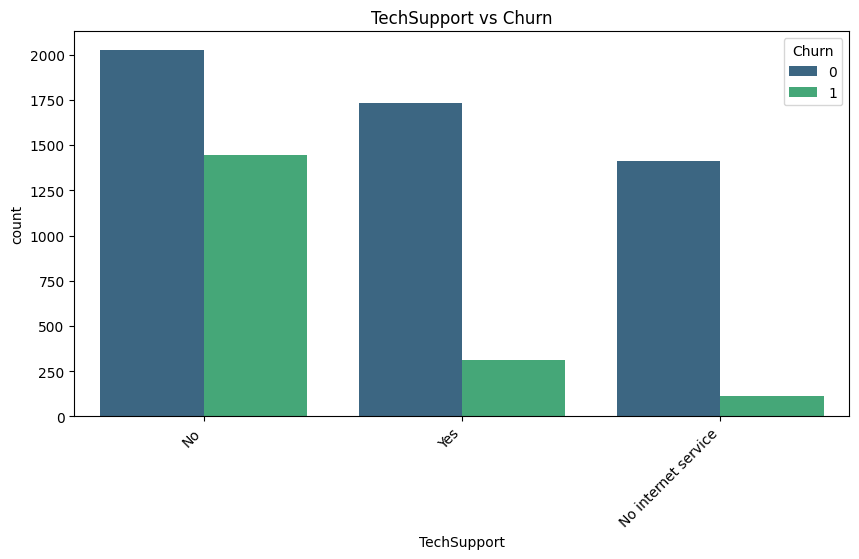

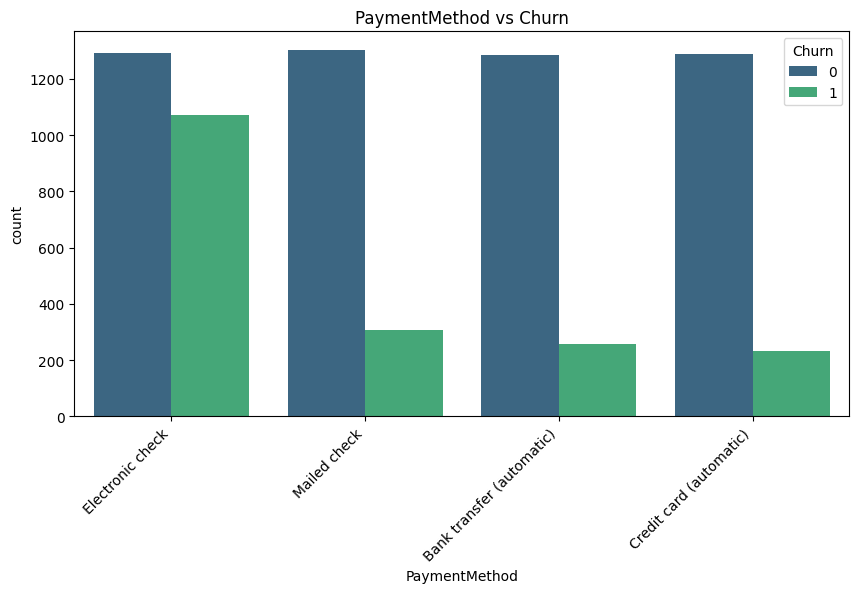

In [23]:
important_cats = ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod']

for col in important_cats:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='Churn', data=df, palette='viridis')
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45, ha='right')
    plt.show()

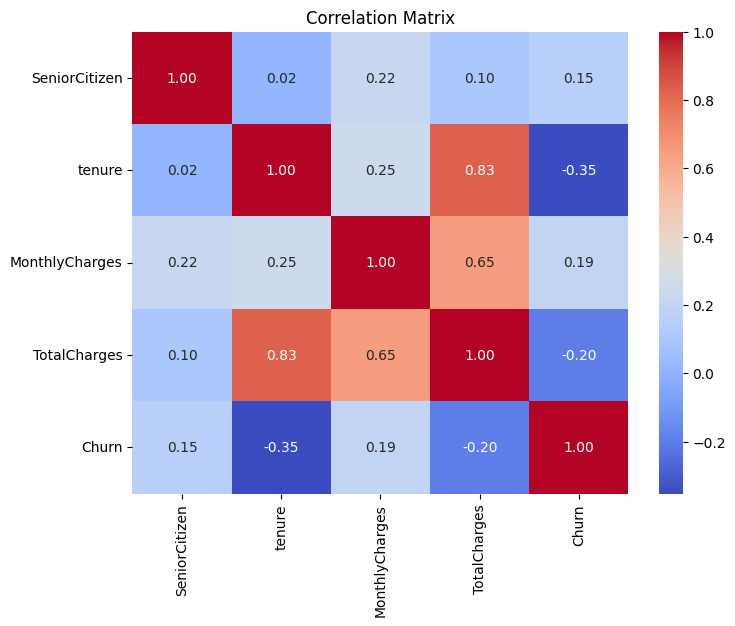

In [24]:
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [25]:
#INSIGHTS: since tenure and TotalCharges are highly correlated, it may introduce multi collinearity...so remove one of them
df = df.drop('TotalCharges', axis=1)

In [26]:
print("Columns after dropping TotalCharges:", df.columns.tolist())

Columns after dropping TotalCharges: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'Churn']


In [27]:
X = df.drop('Churn', axis=1)
y = df['Churn']

print("X shape:", X.shape)          
print("y shape:", y.shape)          
print("Churn rate:", y.mean().round(4))  

X shape: (7043, 18)
y shape: (7043,)
Churn rate: 0.2654


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.2,stratify=y,          # keeps same churn % in train & test coz the dataset is imbalenced 
    random_state=42)

print("Train size:", len(X_train), f"({len(X_train)/len(X)*100:.1f}%)")
print("Test size: ", len(X_test),  f"({len(X_test)/len(X)*100:.1f}%)")
print("Churn rate in train:", y_train.mean().round(4))
print("Churn rate in test: ", y_test.mean().round(4))

Train size: 5634 (80.0%)
Test size:  1409 (20.0%)
Churn rate in train: 0.2654
Churn rate in test:  0.2654


In [29]:
X_train_dummies = pd.get_dummies(X_train, drop_first=True)
X_test_dummies  = pd.get_dummies(X_test, drop_first=True)

X_test_dummies = X_test_dummies.reindex(columns=X_train_dummies.columns, fill_value=0)

print("Shape after dummies → train:", X_train_dummies.shape, "test:", X_test_dummies.shape)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_numeric_scaled = scaler.fit_transform(
    X_train_dummies[['tenure', 'MonthlyCharges']]
)
test_numeric_scaled = scaler.transform(
    X_test_dummies[['tenure', 'MonthlyCharges']]
)

X_train_scaled = X_train_dummies.copy()
X_test_scaled  = X_test_dummies.copy()

X_train_scaled[['tenure', 'MonthlyCharges']] = train_numeric_scaled
X_test_scaled[['tenure', 'MonthlyCharges']]  = test_numeric_scaled


Shape after dummies → train: (5634, 29) test: (1409, 29)


Random Forest model trained!

=== RANDOM FOREST RESULTS ===
              precision    recall  f1-score   support

           0     0.8284    0.8957    0.8607      1035
           1     0.6276    0.4866    0.5482       374

    accuracy                         0.7871      1409
   macro avg     0.7280    0.6911    0.7045      1409
weighted avg     0.7751    0.7871    0.7778      1409

---------------------------------------------
ROC-AUC          : 0.8193
F1-score (Churn) : 0.5482


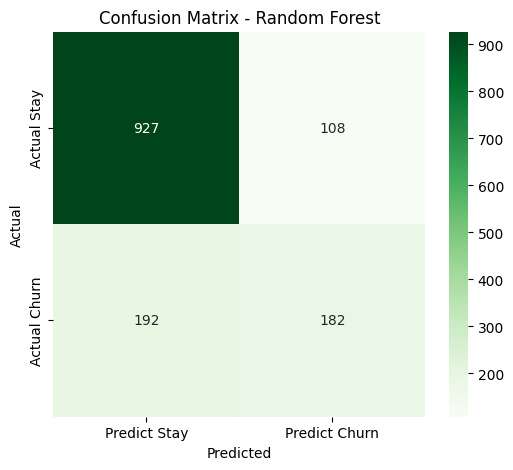

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,           # number of trees (100 is a good default)
    random_state=42,
    class_weight='balanced',    # automatically handles the class imbalance
    max_depth=None,             # let trees grow fully (default)
    min_samples_split=2,
    min_samples_leaf=1
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

print("Random Forest model trained!")

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Print results
print("\n=== RANDOM FOREST RESULTS ===")
print("=" * 45)
print(classification_report(y_test, y_pred_rf, digits=4))
print("-" * 45)
print(f"ROC-AUC          : {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1-score (Churn) : {f1_score(y_test, y_pred_rf):.4f}")
print("=" * 45)

# Optional: Confusion Matrix plot
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predict Stay', 'Predict Churn'],
            yticklabels=['Actual Stay', 'Actual Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [36]:
import pickle

# 1. Save the trained Random Forest model
with open('rf_churn_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
print("Model saved → rf_churn_model.pkl")

# 2. Save the fitted StandardScaler object
#    (this is the scaler you used on tenure & MonthlyCharges)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
print("Scaler saved → scaler.pkl")

# 3. Save the exact column names after pd.get_dummies()
#    (this is very important for prediction later)
with open('model_columns.pkl', 'wb') as file:
    pickle.dump(list(X_train_scaled.columns), file)
print("Column names saved → model_columns.pkl")

Model saved → rf_churn_model.pkl
Scaler saved → scaler.pkl
Column names saved → model_columns.pkl


In [37]:
# Just to make sure everything saved correctly

# Load them back and check types
with open('rf_churn_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
print("Loaded model type:", type(loaded_model))

with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
print("Loaded scaler type:", type(loaded_scaler))

with open('model_columns.pkl', 'rb') as f:
    loaded_columns = pickle.load(f)
print("Number of columns saved:", len(loaded_columns))
print("First 5 column names:", loaded_columns[:5])

Loaded model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Loaded scaler type: <class 'sklearn.preprocessing._data.StandardScaler'>
Number of columns saved: 29
First 5 column names: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender_Male', 'Partner_Yes']
